In [4]:
!export GROQ_API_KEY="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"

In [19]:
import pandas as pd
df = pd.read_parquet("hf://datasets/NebulaByte/E-Commerce_Customer_Support_Conversations/data/train-00000-of-00001-a5a7c6e4bb30b016.parquet")

In [20]:
import os
from groq import Groq

# Set the environment variable
os.environ["GROQ_API_KEY"] = "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"

# Initialize the Groq client
client = Groq(api_key=os.environ.get("GROQ_API_KEY"))


In [63]:
def get_sentiment(title, chat_history, max_retries=3):
    for attempt in range(max_retries):
        try:
            # Create the chat completion request
            chat_completion = client.chat.completions.create(
                messages=[
                    {
                        "role": "system",
                        "content": "You are a Support Agent analyzing conversation sentiment."
                    },
                    {
                        "role": "user",
                        "content": f"""Evaluate the sentiment of this conversation in LOWERCASE:
                        neutral, positive, negative, or frustrated.

                        Conversation Title: "{title}"
                        Conversation History: "{chat_history}"

                        Output ONLY the sentiment category."""
                    }
                ],
                model="llama3-8b-8192",
                max_tokens=10,
                temperature=0.5
            )

            # Extract and validate sentiment
            sentiment = chat_completion.choices[0].message.content.strip().lower()
            valid_sentiments = ['neutral', 'positive', 'negative', 'frustrated']

            return sentiment if sentiment in valid_sentiments else 'neutral'

        except Exception as e:
            print(f"Sentiment Analysis Error: {e}")
            return 'neutral'


In [64]:
def analyze_sentiment_dataset(df):
    # Apply sentiment analysis to a subset of the dataset
    #res = df.apply(lambda x: get_sentiment(x["issue_category_sub_category"], x["conversation"]), axis=1)

    # Prepare true and predicted labels
    # min_len = min(len(df["customer_sentiment"]), len(res))
    y_true = df["customer_sentiment"]
    y_pred = df['predicted_sentiment']

    # Define sentiment labels
    labels = ['frustrated', 'negative', 'neutral', 'positive']

    # Create confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title("Sentiment Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Calculate and print F1 scores
    print("Sentiment Analysis Metrics:")
    print(classification_report(y_true, y_pred, labels=labels))

    return y_true, y_pred

In [65]:
def main(df):
    sample_df = df.iloc[:50]

    # Apply sentiment analysis
    sample_sentiments = sample_df.apply(
        lambda x: get_sentiment(x["issue_category_sub_category"], x["conversation"]),
        axis=1
    )

    # Add predicted sentiments
    sample_df['predicted_sentiment'] = sample_sentiments

    # Display and analyze results
    print(sample_df[['issue_category_sub_category', 'customer_sentiment', 'predicted_sentiment']])
    analyze_sentiment_dataset(sample_df)

<ipython-input-65-260622a77826>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['predicted_sentiment'] = sample_sentiments


                          issue_category_sub_category customer_sentiment  \
0   Mobile Number and Email Verification -> Verifi...            neutral   
1   Pickup and Shipping -> Reasons for being asked...            neutral   
2   Replacement and Return Process -> Inability to...            neutral   
3   Login Issues and Error Messages -> Error messa...            neutral   
4   Order Delivery Issues -> Delivery not attempte...           negative   
5   Account Reactivation and Deactivation -> React...           negative   
6   Cash on Delivery (CoD) Refunds -> Refund timel...         frustrated   
7   Product Availability and Status -> Ordering 'O...            neutral   
8   Product Installation -> Installation after del...           negative   
9   Mobile Number and Email Verification -> Issues...           negative   
10  Order Cancellation -> Time taken to cancel an ...            neutral   
11  Lost or Missing Warranty Card -> Obtaining war...            neutral   
12  Order De

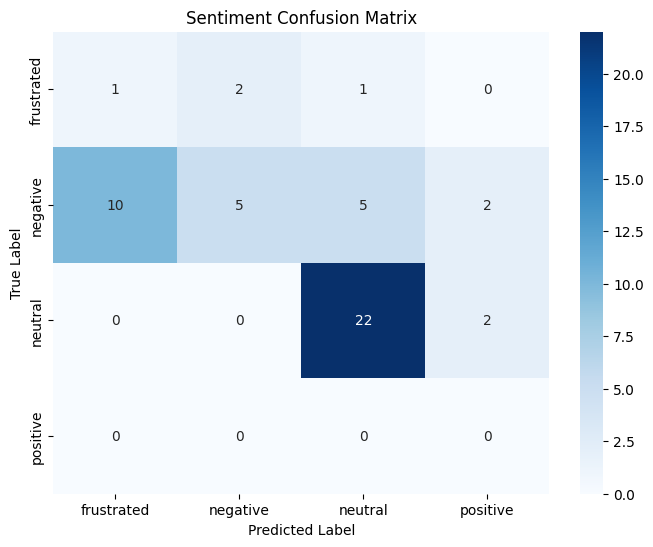

Sentiment Analysis Metrics:
              precision    recall  f1-score   support

  frustrated       0.09      0.25      0.13         4
    negative       0.71      0.23      0.34        22
     neutral       0.79      0.92      0.85        24
    positive       0.00      0.00      0.00         0

    accuracy                           0.56        50
   macro avg       0.40      0.35      0.33        50
weighted avg       0.70      0.56      0.57        50



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [66]:
# Assuming 'df' is your loaded DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
main(df)